In [1]:
import operator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import feature_selection
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler, RobustScaler, Imputer, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from IPython.core.pylabtools import figsize 
%matplotlib inline

In [6]:
RANDOM_STATE = 42
DATA_EXTERNAL = "../data/external/"
DATA_PROCESSED = "../data/processed/"
DATA_INTERIM = "../data/interim/"

In [7]:
model_dict = {
    'rf':{'pipe':('rf', RandomForestClassifier(random_state=RANDOM_STATE)),
          'params':[{'rf__max_depth':[2, 3, 5, 10, 15], 'rf__n_estimators':[3, 5, 7, 10, 50], 'rf__max_features':[1,2]}],
          'name':'RandomForest'
    },
    'lr':{'pipe':('lr', LogisticRegression()),
        'params':[{'lr__C': [.001, .01, .1, 1, 10, 100, 1000], 'lr__class_weight': [None, 'balanced']}],
        'name':'LogisticRegression'
    },
    'svc':{'pipe':('svc', SVC(kernel='rbf')), 
        'params':[{'svc__C': [1,10,100,1000], 'svc__gamma': [1,0.1,0.001,0.0001]}],
        'name': 'SupportVectorClassifier(RBF)'
    }
}

#### Random Forest

In [8]:
algorithm = 'rf'
model = Pipeline([('imputer', Imputer(missing_values="NaN", strategy="median")), 
                  model_dict[algorithm]['pipe']])
# model = Pipeline([('imputer', Imputer(missing_values="NaN", strategy="median")), ('scaler', StandardScaler()),
#                   model_dict[algorithm]['pipe']])
param_list = [model_dict[algorithm]['params']][0]

folds = 3
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=RANDOM_STATE)

In [11]:
rf_train_scores = []
rf_test_scores = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for i in range(20):
    train = pd.read_csv(DATA_PROCESSED + "1/train_test_sets/train_{}.csv".format(i), index_col="MUTANT")
    test = pd.read_csv(DATA_PROCESSED + "1/train_test_sets/test_{}.csv".format(i), index_col="MUTANT")
    X_train = train.drop("TYPE", 1)
    y_train = train.TYPE
    X_test = test.drop("TYPE", 1)
    y_test = test.TYPE
    le = LabelEncoder().fit(y_train)
    gs = GridSearchCV(model, param_list, cv=skf.split(X_train, y_train), 
                      n_jobs=3, scoring='roc_auc', verbose=1, refit=True)
    
    gs.fit(X_train, le.transform(y_train))
    
    
    print("Parameters ({}): {}".format(i, gs.best_params_))
    print("Score train ({}): {}".format(i, gs.best_score_))
    
    
    rf = gs.best_estimator_
    y_pred = rf.predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(le.transform(y_test), y_pred[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    test_score = roc_auc_score(le.transform(y_test), y_pred[:, 1])
    
    
    print("Score test ({}): {}".format(i, test_score))
    rf_test_scores.append(test_score)
    rf_train_scores.append(gs.best_score_)
    


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    7.7s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   36.7s finished


Parameters (0): {'rf__max_depth': 15, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (0): 0.7130060351223263
Score test (0): 0.7078467794052523
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    7.3s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   37.7s finished


Parameters (1): {'rf__max_depth': 10, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (1): 0.7117158169819953
Score test (1): 0.7129141825912596
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    7.1s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   37.0s finished


Parameters (2): {'rf__max_depth': 10, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (2): 0.708970324878078
Score test (2): 0.7282071912959573
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    7.3s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   35.0s finished


Parameters (3): {'rf__max_depth': 10, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (3): 0.7111875921046922
Score test (3): 0.7120328431259302
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    7.6s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   35.6s finished


Parameters (4): {'rf__max_depth': 10, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (4): 0.7116085499394058
Score test (4): 0.7150816869238695
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    6.6s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   34.5s finished


Parameters (5): {'rf__max_depth': 10, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (5): 0.7110525589582258
Score test (5): 0.7159469077260976
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    7.2s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   35.9s finished


Parameters (6): {'rf__max_depth': 10, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (6): 0.7142102605333874
Score test (6): 0.7059026172513245
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    7.6s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   40.6s finished


Parameters (7): {'rf__max_depth': 10, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (7): 0.7106372631705845
Score test (7): 0.7105247611786824
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    6.9s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   36.1s finished


Parameters (8): {'rf__max_depth': 15, 'rf__max_features': 1, 'rf__n_estimators': 50}
Score train (8): 0.7108901350573822
Score test (8): 0.7172785429790742
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    7.3s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   37.5s finished


Parameters (9): {'rf__max_depth': 15, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (9): 0.7119939586444508
Score test (9): 0.7175814959517901
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    7.1s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   35.5s finished


Parameters (10): {'rf__max_depth': 15, 'rf__max_features': 1, 'rf__n_estimators': 50}
Score train (10): 0.7131586910592334
Score test (10): 0.7175556317378513
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    6.7s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   36.1s finished


Parameters (11): {'rf__max_depth': 15, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (11): 0.7111951855853932
Score test (11): 0.7133977247812185
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    7.5s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   36.6s finished


Parameters (12): {'rf__max_depth': 10, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (12): 0.7113283997752999
Score test (12): 0.711740591670891
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    9.8s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   54.8s finished


Parameters (13): {'rf__max_depth': 10, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (13): 0.7108191614086449
Score test (13): 0.7120855717783718
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   11.1s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   44.9s finished


Parameters (14): {'rf__max_depth': 15, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (14): 0.7125442985886463
Score test (14): 0.7177146585919334
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    7.5s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   37.5s finished


Parameters (15): {'rf__max_depth': 10, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (15): 0.7124744005233211
Score test (15): 0.7095700512584109
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    8.4s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   37.8s finished


Parameters (16): {'rf__max_depth': 10, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (16): 0.7089517212417797
Score test (16): 0.7179545266047784
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    7.5s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   40.2s finished


Parameters (17): {'rf__max_depth': 10, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (17): 0.7125718835244409
Score test (17): 0.7088605999417745
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    9.6s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   40.1s finished


Parameters (18): {'rf__max_depth': 10, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (18): 0.7100746498274618
Score test (18): 0.7139023690540081
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    6.9s
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:   33.7s finished


Parameters (19): {'rf__max_depth': 10, 'rf__max_features': 2, 'rf__n_estimators': 50}
Score train (19): 0.7124690248678343
Score test (19): 0.7081516885693717


In [12]:
pd.DataFrame(tprs).to_csv("../results/1/rf_cons_only_tprs.csv", index=False)
pd.Series(aucs).to_csv("../results/1/rf_cons_only_aucs.csv", index=False)

In [13]:
pd.DataFrame(tprs).to_csv("../results/1/rf_tprs.csv", index=False)
pd.Series(aucs).to_csv("../results/1/rf_aucs.csv", index=False)

In [14]:
print("MEAN TRAIN: ", np.mean(rf_train_scores))
print("STDDEV TRAIN: ", np.std(rf_train_scores))
print("MEAN TEST: ", np.mean(rf_test_scores))
print("STDDEV TEST: ", np.std(rf_test_scores))

MEAN TRAIN:  0.71154299559
STDDEV TRAIN:  0.00129774435183
MEAN TEST:  0.713712521121
STDDEV TEST:  0.00490278450369


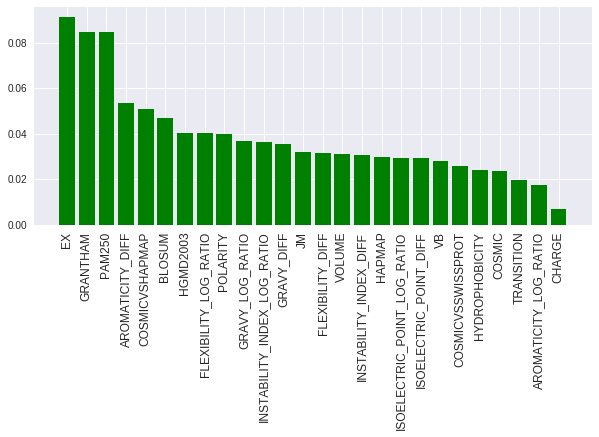

In [23]:
importances = [(X_train.columns[e], x) for e, x in enumerate(rf.steps[1][1].feature_importances_)]
importances.sort(key=operator.itemgetter(1), reverse=True)
figsize(10,4)
# plt.title("Importancia", fontsize=16)
plt.bar(np.arange(len(importances)), [y for x, y in importances], color="g", align="center")
plt.xticks(range(len(importances)), [x for x, y in importances], rotation='vertical', fontsize=12)
# plt.xlim([0, range(len(importances))])
plt.show()

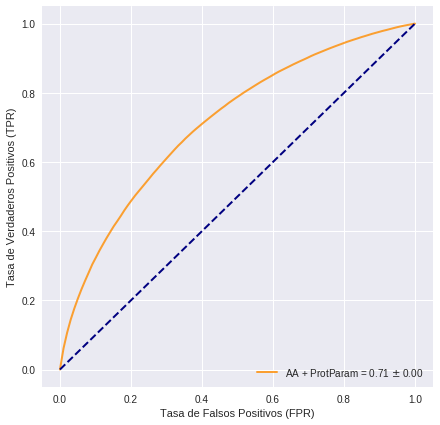

In [21]:
figsize(7,7)

rf_tprs = pd.read_csv("../results/1/rf_tprs.csv")
rf_aucs = pd.read_csv("../results/1/rf_aucs.csv")

# lr_tprs = pd.read_csv("../results/humsavar/rf_cons_only_tprs.csv")
# lr_aucs = pd.read_csv("../results/humsavar/rf_cons_only_aucs.csv")

def plot_auc_curve(tprs, aucs, color, label):
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    plt.plot(mean_fpr, mean_tpr, color=color,
             label=label % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
plot_auc_curve(rf_tprs, rf_aucs, 'darkorange', r'AA + ProtParam = %0.2f $\pm$ %0.2f')
# plot_auc_curve(lr_tprs, lr_aucs, 'darkgreen', r'PhastCons/phyloP = %0.2f $\pm$ %0.2f)')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
# plt.title('AUC Curve')
plt.legend(loc="lower right")

plt.show()